<a href="https://colab.research.google.com/github/MaralAminpour/ML-BME-UofA/blob/main/Week-11-COVID-chest-x-ray/deep_learning_covid19_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting COVID-19 with Chest X-Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Objectives

In this notebook, we are going to focus on the following learning objectives:

- Create custom Dataset and DataLoader in PyTorch

- Train a ResNet-18 model in PyTorch to perform Image Classification

- By the end of this course, you will be able to create Convolutional Neural Networks, and will be able to train it to classify Chest X-Ray scans with reasonably high accuracy.

Project Structure

The hands on project on Detecting COVID-19 with Chest X-Ray using PyTorch is divided into following tasks:

Task 1: Introduction

Task 2: Importing Libraries

Task 3: Creating Custom Dataset

Task 4: Image Transformations

Task 5: Prepare DataLoader

Task 6: Data Visualization

Task 7: Creating the Model

Task 8: Training the Model

Task 9: Final Results



# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.1.0+cu118


The code is a setup script for a Python-based image processing project using PyTorch. It begins with a Jupyter Notebook specific command to enable inline display of matplotlib plots. It imports essential libraries: `os` and `shutil` for file operations, `random` for random number generation, PyTorch for deep learning, `torchvision` for computer vision tasks, `numpy` for numerical operations, and `PIL.Image` along with `matplotlib.pyplot` for image manipulation and plotting. The script sets a fixed seed for random number generation in PyTorch to ensure reproducibility, and it concludes by printing the version of PyTorch being used, which is crucial for ensuring compatibility and debugging.

# Preparing Training and Test Sets

In [2]:
#dataset = 'covid_data_small'
#!git clone https://github.com/SirTurtle/covid_data_small.git

dataset = 'covid_data_large'
!git clone https://github.com/SirTurtle/covid_data_large.git

Cloning into 'covid_data_large'...
remote: Enumerating objects: 3912, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 3912 (delta 0), reused 7 (delta 0), pack-reused 3899
Receiving objects: 100% (3912/3912), 144.22 MiB | 43.07 MiB/s, done.
Updating files: 100% (3602/3602), done.


# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

This code defines a custom dataset class, `ChestXRayDataset`, for use in a PyTorch machine learning project, specifically for handling chest X-ray images. This class is a subclass of `torch.utils.data.Dataset`, which is a standard way in PyTorch to create datasets.

1. **Initialization (`__init__` method)**: When an instance of the class is created, it initializes with two parameters: `image_dirs`, a dictionary specifying the directories for each class of images (like 'normal', 'viral', 'covid'), and `transform`, which is likely a series of image transformations to be applied to the images. The `get_images` function within `__init__` is used to list and count the PNG images in each class directory. The images for each class are stored in a dictionary `self.images`.

2. **Length Method (`__len__` method)**: This method returns the total number of images across all classes. It's a required method for PyTorch datasets and is used to get the dataset's size.

3. **Get Item Method (`__getitem__` method)**: This method is used to retrieve a specific item from the dataset. It randomly selects a class, then an image from that class, based on the provided index. The selected image is then opened, converted to RGB (regardless of its original color channels), and transformed using the provided transformations. The method returns a tuple containing the transformed image and the index of its class. This method is crucial for iterating over the dataset during training or evaluation in a PyTorch model.

Overall, `ChestXRayDataset` is a tailored dataset loader, which is essential for feeding image data into a neural network during training or evaluation, especially in medical imaging tasks like detecting conditions from chest X-rays. It handles the loading, transformation, and batching of images, which are key steps in preparing data for a deep learning model.

**In summary:** The `ChestXRayDataset` class in this code is a custom dataset handler for a PyTorch machine learning project, designed specifically for chest X-ray images. It inherits from `torch.utils.data.Dataset` and initializes with directories of X-ray images and specified transformations. The class features a method to load and count PNG images from each class ('normal', 'viral', 'covid'), storing them in a structured manner. It implements the necessary PyTorch dataset methods: `__len__` to report the total count of images, and `__getitem__` to retrieve a specific image. In `__getitem__`, it randomly selects an image from one of the classes, applies the given transformations, and returns the transformed image along with its class label. This setup is crucial for efficiently managing and preprocessing image data for neural network training in medical image analysis tasks.

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

This code snippet defines two sets of image transformations using PyTorch's `torchvision.transforms` module, one for training (`train_transform`) and one for testing (`test_transform`). Both sets resize images to 224x224 pixels and convert them to tensors, followed by normalization with specified mean and standard deviation values. The training transformation includes an additional step of randomly flipping images horizontally to introduce variability and reduce overfitting. These transformations are essential in machine learning workflows, particularly in image processing tasks, as they standardize input data and help improve model generalization. The `Compose` function is used in both cases to chain these transformations together, ensuring they are applied sequentially to each image.

The provided code defines two sets of image transformations for a machine learning model, specifically designed for different stages of the model's workflow: training and testing. The `train_transform` includes resizing images to 224x224 pixels, applying a random horizontal flip to introduce variability, converting images to tensors for PyTorch compatibility, and normalizing them using specific mean and standard deviation values. This combination of transformations aims to augment the training data for better generalization. On the other hand, the `test_transform` set, used for evaluating the model, omits the random flipping but includes the same resizing, tensor conversion, and normalization steps. These transformations ensure consistency in image format and scale between the training and testing phases, which is crucial for the effective training and evaluation of deep learning models in computer vision tasks.

# Prepare DataLoader

In [5]:
train_dirs = {
    'normal': '{}/train/normal'.format(dataset),
    'viral': '{}/train/viral'.format(dataset),
    'covid': '{}/train/covid'.format(dataset)
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1000 normal examples
Found 1000 viral examples
Found 1000 covid examples


In this code snippet, a training dataset is being set up for a machine learning project involving chest X-ray images for COVID-19 detection. Initially, `train_dirs` is defined as a dictionary that maps class names ('normal', 'viral', 'covid') to their respective directories within the 'COVID-19 Radiography Database'. This dictionary provides a structured way to access the image data for each category. Then, an instance of the `ChestXRayDataset` class is created, named `train_dataset`, using these directories and the previously defined `train_transform` as inputs. This instance will serve as the training dataset, where `ChestXRayDataset` is presumably a custom class designed to handle loading, transforming, and serving the X-ray images from the specified directories. By passing `train_transform`, the images in this dataset will undergo the specified preprocessing steps, such as resizing, random flipping, and normalization, making them ready for use in training a machine learning model.

In [6]:
test_dirs = {
    'normal': '{}/validation/normal'.format(dataset),
    'viral': '{}/validation/viral'.format(dataset),
    'covid': '{}/validation/covid'.format(dataset)
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 100 normal examples
Found 100 viral examples
Found 100 covid examples


The code snippet is setting up a test dataset for a machine learning model focusing on chest X-ray images for COVID-19 detection. It defines `test_dirs`, a dictionary that maps class labels ('normal', 'viral', 'covid') to their respective image directories within a test subset of the 'COVID-19 Radiography Database'. Subsequently, it creates an instance of the `ChestXRayDataset` class named `test_dataset` using these directories and the `test_transform` transformations. This setup ensures that the test dataset is processed and structured in a similar manner to the training dataset, but with potentially different transformations (as specified in `test_transform`), and is used for evaluating the model's performance.

__Note: The 'test_dataset' is being used as a validation set, not as a test set.__

In [7]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 500
Number of test batches 50


This code sets up data loaders for training and testing datasets in a machine learning project, with a specified batch size of 6. `dl_train` and `dl_test` are created as instances of PyTorch's `DataLoader` class, using `train_dataset` and `test_dataset` respectively, and both are set to shuffle the data. This shuffling is useful for ensuring that each batch is different, helping the model learn more effectively. The batch size determines how many images are passed through the network at one time during training or testing. Finally, the code prints the number of batches in each of the training and testing datasets, which is a direct result of the dataset sizes and the chosen batch size.

# Data Visualization

In [8]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

This code sets up data loaders for training and testing datasets in a machine learning project, with a specified batch size of 6. `dl_train` and `dl_test` are created as instances of PyTorch's `DataLoader` class, using `train_dataset` and `test_dataset` respectively, and both are set to shuffle the data. This shuffling is useful for ensuring that each batch is different, helping the model learn more effectively. The batch size determines how many images are passed through the network at one time during training or testing. Finally, the code prints the number of batches in each of the training and testing datasets, which is a direct result of the dataset sizes and the chosen batch size.

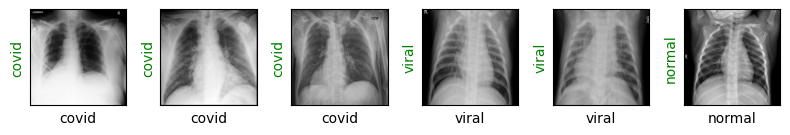

In [9]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

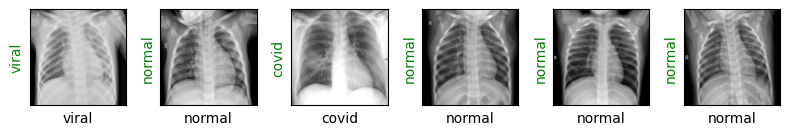

In [10]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In short, this code retrieves and displays the first batch of images and their corresponding labels from both the training and testing datasets. It uses `next(iter(dl_train))` and `next(iter(dl_test))` to obtain the first batch from each DataLoader (`dl_train` and `dl_test`). The `show_images` function is then called with these images and labels to visualize them. This process is likely used for verifying the data loading and preprocessing steps, ensuring that the images and labels are correctly aligned and formatted before proceeding with training or testing the model.

# Creating the Model

In [11]:
resnet18 = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

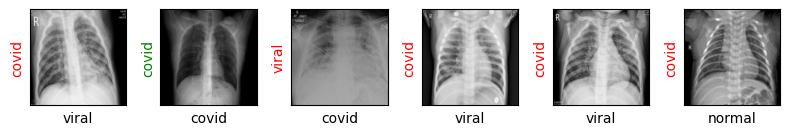

In [14]:
show_preds()

This code snippet is configuring and testing a ResNet-18 model for image classification using PyTorch. First, it loads a pretrained ResNet-18 model from PyTorch's model library. It then modifies the final fully connected layer (`resnet18.fc`) of the model to output three classes (presumably corresponding to 'normal', 'viral', 'covid'). A cross-entropy loss function and an Adam optimizer with a learning rate of 3e-5 are set up for training the model. The `show_preds` function puts the model in evaluation mode, retrieves a batch of images from the test dataset (`dl_test`), and computes the model's predictions. It then visualizes these images alongside their true labels and predicted labels using the `show_images` function. This allows for a quick visual assessment of the model's performance on the test data.

# Training the Model

In [15]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

__Timing data:__

- covid_data_small, 1 epoch, MacBook Pro: 21 s
- covid_data_small, 10 epochs, MacBook Pro: 1 min 16 s
- covid_data_small, 100 epochs, MacBook Pro: 3 min 36 s
- covid_data_large, 1 epoch, MacBook Pro: 28.7 s
- covid_data_large, 10 epochs, MacBook Pro: 27.7 s
- covid_data_large, 100 epochs, MacBook Pro: 35.6 s
- covid_data_large, 100 epochs, Colab (CPU): 5 min 9 s
- covid_data_large, 100 epochs, Colab (T4 GPU): 2 min 56 s

Starting training..
Starting epoch 1/100
Evaluating at step 0
Validation Loss: 1.2278, Accuracy: 0.2167


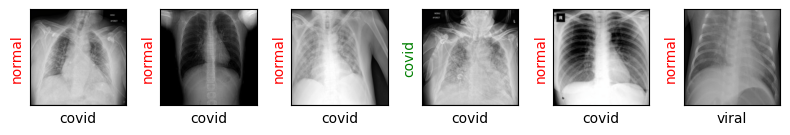

Evaluating at step 20
Validation Loss: 0.6707, Accuracy: 0.7667


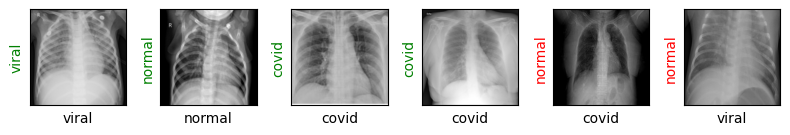

Evaluating at step 40
Validation Loss: 0.4075, Accuracy: 0.9067


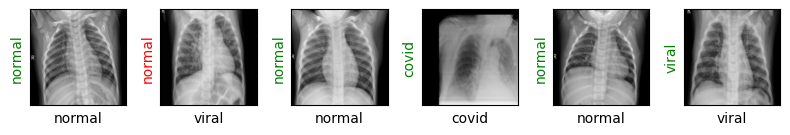

Evaluating at step 60
Validation Loss: 0.2022, Accuracy: 0.9500


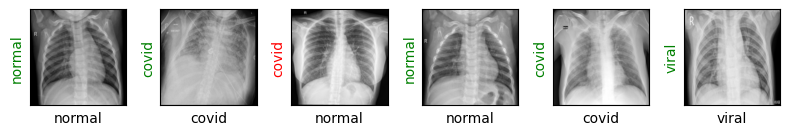

Performance condition satisfied, stopping..
CPU times: user 2min 54s, sys: 2.88 s, total: 2min 56s
Wall time: 2min 56s


In [16]:
%%time

train(epochs=100)

# Final Results

# Saving the Model

In [17]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

This line of code uses PyTorch's `torch.save` function to save the trained state of the `resnet18` model to a file named 'covid_classifier.pt'. Specifically, it saves the model's state dictionary, which includes parameters like weights and biases learned during training. This file can later be loaded to recreate the model in its trained state, allowing for reuse without needing to retrain from scratch. This is particularly useful for deploying the model in different environments, sharing it with others, or for further analysis and testing. The '.pt' extension is commonly used for PyTorch model files.

# Inference on a Single Image

In [18]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

This code loads a pre-trained ResNet-18 model and modifies its final layer to output three classes. It then loads the model's learned parameters from a saved file ('covid_classifier.pt') and sets the model to evaluation mode. The `predict_image_class` function defined in the code is used to predict the class of a given image. It opens the image, applies the `test_transform` (presumably including resizing, tensor conversion, and normalization), and adds a batch dimension. The model then predicts the output for this image, and a softmax function is applied to the output to obtain probabilities for each class. The function finally returns these probabilities, the index of the predicted class, and the corresponding class name (from an earlier defined `class_names` array). This setup is commonly used for making and interpreting predictions from a trained deep learning model in tasks like image classification.

In [20]:
image_path = 'covid_data_large/test/covid/COVID-1101.png'
#image_path = 'covid_data_small/test/covid/COVID-201.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [0.01573139 0.02756565 0.95670295]
Predicted class index: 2
Predicted class name: covid


This code snippet uses the previously defined `predict_image_class` function to classify an image located at a specific file path (`'/path/to/image/to/test'`). It calls the function with this image path, which processes the image, uses the trained ResNet-18 model to predict its class, and returns the probabilities for each class, the index of the predicted class, and the name of the predicted class. The returned values are stored in `probabilities`, `predicted_class_index`, and `predicted_class_name` respectively. These are then printed out, showing the probability distribution across classes, the index of the class with the highest probability (indicating the model's prediction), and the human-readable name of this predicted class. This is a typical way to use a trained machine learning model for inference on new, unseen data.